In [1]:
using BenchmarkTools

In [2]:
function rotate(matrix)
    return reverse(reverse(matrix, dims=1), dims=2)
end

rotate (generic function with 1 method)

In [3]:
function Convolution_2d_pad(input, kernel; bias=0., padding=false)
    input_rows, input_columns = size(input)
    kernel_height, kernel_width = size(kernel)

    if padding
        padded_input = zeros(Float32, input_rows + 2*kernel_height - 2, input_columns + 2*kernel_width - 2)
        padded_input[kernel_height:end-kernel_height+1, kernel_width:end-kernel_width+1] .= input
        input_rows, input_columns = size(padded_input)
        input = padded_input
    end

    output_rows = input_rows - kernel_height + 1
    output_columns = input_columns - kernel_width + 1
    output = zeros(Float32, output_rows, output_columns)


    for c in 1:output_columns
        for r in 1:output_rows
            patch = @view input[r:r+kernel_height-1, c:c+kernel_width-1]
            output[r, c] = sum(patch .* kernel) + bias
        end
    end
    return output
end

Convolution_2d_pad (generic function with 1 method)

In [4]:
function Convolution_2d(input, kernel; bias=0.)
    input_rows, input_columns = size(input)
    kernel_height, kernel_width = size(kernel)

    output_rows = input_rows - kernel_height + 1
    output_columns = input_columns - kernel_width + 1
    output = zeros(Float32, output_rows, output_columns)


    for c in 1:output_columns
        for r in 1:output_rows
            patch = @view input[r:r+kernel_height-1, c:c+kernel_width-1]
            output[r, c] = sum(patch .* kernel) + bias
        end
    end
    return output
end

Convolution_2d (generic function with 1 method)

In [27]:
function Convolution_2d!(ret, input, kernel; bias=0., padding=false)
    input_rows, input_columns = size(input)
    kernel_height, kernel_width = size(kernel)

    if padding
        padded_input = zeros(Float32, input_rows + 2*kernel_height - 2, input_columns + 2*kernel_width - 2)
        padded_input[kernel_height:end-kernel_height+1, kernel_width:end-kernel_width+1] .= input
        input_rows, input_columns = size(padded_input)
        input = padded_input
    end

    output_rows = input_rows - kernel_height + 1
    output_columns = input_columns - kernel_width + 1
    sumret = zeros(size(kernel))
    for c in 1:output_columns
        for r in 1:output_rows
            patch = @view input[r:r+kernel_height-1, c:c+kernel_width-1]
            sumret .= patch .* kernel
            ret[r, c] = sum(sumret) + bias
            sumret .= 0.0
        end
    end
end

function Convolution_2d_v2!(ret, sumret, input, kernel; bias=0., padding=false)
    input_rows, input_columns = size(input)
    kernel_height, kernel_width = size(kernel)

    if padding
        padded_input = zeros(Float32, input_rows + 2*kernel_height - 2, input_columns + 2*kernel_width - 2)
        padded_input[kernel_height:end-kernel_height+1, kernel_width:end-kernel_width+1] .= input
        input_rows, input_columns = size(padded_input)
        input = padded_input
    end

    output_rows = input_rows - kernel_height + 1
    output_columns = input_columns - kernel_width + 1
    for c in 1:output_columns
        for r in 1:output_rows
            patch = @view input[r:r+kernel_height-1, c:c+kernel_width-1]
            sumret .= patch .* kernel
            ret[r, c] = sum(sumret) + bias
            sumret .= 0.0
        end
    end
end

function Convolution_2d_v3!(ret, input, kernel; bias=0., padding=false)
    input_rows, input_columns = size(input)
    kernel_height, kernel_width = size(kernel)

    output_rows = input_rows - kernel_height + 1
    output_columns = input_columns - kernel_width + 1
    for c in 1:kernel_width
        for r in 1:kernel_height
            @views ret .+= input[r:r+input_rows-kernel_height, c:c+input_columns-kernel_width] .* kernel[r,c]
        end
    end
    ret .+= bias
end

Convolution_2d_v3! (generic function with 1 method)

In [6]:
function Conv_backward_v1( input, weights, bias, gradient)
    input_height, input_width, input_channels = size(input)
    output_height, output_width, output_channels = size(gradient)
    kernel_height, kernel_width, _, _ = size(weights)
    
    
    grad_input = zeros(Float32, size(input))
    for k in 1:input_channels
        for c in 1:output_channels
            grad_input[:, :, k] += Convolution_2d_pad(weights[:, :, k, c], gradient[:, :, c]; padding=true)
        end
    end

    grad_weights = zeros(Float32, size(weights))
    for k in 1:input_channels
        for c in 1:output_channels
            grad_weights[:, :, k, c] += Convolution_2d(input[:, :, k], gradient[:, :, c])
        end
    end

    grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
    
    return grad_input, grad_weights, grad_bias
end

Conv_backward_v1 (generic function with 1 method)

In [7]:
function Conv_backward_v2(input, weights, bias, gradient)
    input_height, input_width, input_channels = size(input)
    output_height, output_width, output_channels = size(gradient)
    kernel_height, kernel_width, _, _ = size(weights)
    
    
    grad_input = zeros(Float32, size(input))
    grad_weights = zeros(Float32, size(weights))
    
    tmp_weights = zeros(Float32, kernel_height, kernel_width)
    tmp_input = zeros(Float32, input_height, input_width)
    tmp_gradient = zeros(Float32, output_height, output_width)
    
    for k in 1:input_channels
        for c in 1:output_channels
            tmp_weights .= @views weights[:, :, k, c]
            tmp_gradient .= @views gradient[:, :, c]
            grad_input[:, :, k] .+= Convolution_2d_pad(tmp_weights, rotate(tmp_gradient); padding=true)
        end
    end

    
    for k in 1:input_channels
        for c in 1:output_channels
            tmp_input .= @views input[:, :, k]
            tmp_gradient .= @views gradient[:, :, c]
            grad_weights[:, :, k, c] += Convolution_2d(tmp_input, tmp_gradient)
        end
    end

    grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
    
    return grad_input, grad_weights, grad_bias
end

Conv_backward_v2 (generic function with 1 method)

In [8]:
function Conv_backward_v3( input, weights, bias, gradient)
    input_height, input_width, input_channels = size(input)
    output_height, output_width, output_channels = size(gradient)
    kernel_height, kernel_width, _, _ = size(weights)
    
    grad_input = zeros(Float32, size(input))
    grad_weights = zeros(Float32, size(weights))
    
    tmp_weights = zeros(Float32, kernel_height, kernel_width)
    tmp_input = zeros(Float32, input_height, input_width)
    tmp_gradient = zeros(Float32, output_height, output_width)
    
    for k in 1:input_channels
        for c in 1:output_channels
            tmp_weights .= @views weights[:, :, k, c]
            tmp_gradient .= @views gradient[:, :, c]
            for i = 1:output_height
                for j = 1:output_width
                    grad_input[i:i+kernel_height-1, j:j+kernel_width-1, k] .+= (tmp_weights .* tmp_gradient[i,j]);
                end
            end
        end
    end
    
    for k in 1:input_channels
        for c in 1:output_channels
            tmp_input .= @views input[:, :, k]
            tmp_gradient .= @views gradient[:, :, c]
            grad_weights[:, :, k, c] += Convolution_2d(tmp_input, tmp_gradient)
        end
    end

    grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
    
    return grad_input, grad_weights, grad_bias
end

Conv_backward_v3 (generic function with 1 method)

In [9]:
function Conv_backward_v4(input, weights, bias, gradient)
    input_height, input_width, input_channels = size(input)
    output_height, output_width, output_channels = size(gradient)
    kernel_height, kernel_width, _, _ = size(weights)
    
    grad_input = zeros(Float32, size(input))
    grad_weights = zeros(Float32, size(weights))
    
    tmp_weights = zeros(Float32, kernel_height, kernel_width)
    tmp_input = zeros(Float32, input_height, input_width)
    tmp_gradient = zeros(Float32, output_height, output_width)
    
    for k in 1:input_channels
        for c in 1:output_channels
            tmp_weights .= @views weights[:, :, k, c]
            tmp_gradient .= @views gradient[:, :, c]
            for i = 1:output_height
                for j = 1:output_width
                    grad_input[i:i+kernel_height-1, j:j+kernel_width-1, k] .+= (tmp_weights .* tmp_gradient[i,j]);
                end
            end
        end
    end
    
    for k in 1:input_channels
        for c in 1:output_channels
            tmp_input .= @views input[:, :, k]
            tmp_gradient .= @views gradient[:, :, c]
            Convolution_2d!(tmp_weights, tmp_input, tmp_gradient)
            grad_weights[:, :, k, c] .+= tmp_weights
            tmp_weights .= 0
        end
    end

    grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
    
    return grad_input, grad_weights, grad_bias
end

Conv_backward_v4 (generic function with 1 method)

In [10]:
function Conv_backward_v5(input, weights, bias, gradient)
  input_height, input_width, input_channels = size(input)
  output_height, output_width, output_channels = size(gradient)
  kernel_height, kernel_width, _, _ = size(weights)
  
  grad_input = zeros(Float32, size(input))
  grad_weights = zeros(Float32, size(weights))
  
  tmp_weights = zeros(Float32, kernel_height, kernel_width)
  tmp_input = zeros(Float32, input_height, input_width)
  tmp_gradient = zeros(Float32, output_height, output_width)
  tmp_weight_gradient = zeros(Float32, kernel_height, kernel_width)
  for k in 1:input_channels
      for c in 1:output_channels
          for i = 1:output_height
              for j = 1:output_width
                  @views grad_input[i:i+kernel_height-1, j:j+kernel_width-1, k] .+= (weights[:, :, k, c] .* gradient[i, j, c]);
              end
          end
      end
  end
  
  for k in 1:input_channels
      for c in 1:output_channels
          tmp_weights .= 0
          tmp_input .= @views input[:, :, k]
          tmp_gradient .= @views gradient[:, :, c]
          Convolution_2d!(tmp_weights, tmp_input, tmp_gradient)
          grad_weights[:, :, k, c] .+= tmp_weights
      end
  end

  grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
  
  return grad_input, grad_weights, grad_bias
end

Conv_backward_v5 (generic function with 1 method)

In [11]:
function Conv_backward_v6(input, weights, bias, gradient)
  input_height, input_width, input_channels = size(input)
  output_height, output_width, output_channels = size(gradient)
  kernel_height, kernel_width, _, _ = size(weights)
  
  grad_input = zeros(Float32, size(input))
  grad_weights = zeros(Float32, size(weights))
  
  tmp_weights = zeros(Float32, kernel_height, kernel_width)
  tmp_input = zeros(Float32, input_height, input_width)
  tmp_gradient = zeros(Float32, output_height, output_width)
  tmp_weight_gradient = zeros(Float32, kernel_height, kernel_width)
  for k in 1:input_channels
      for c in 1:output_channels
          for i = 1:output_height
              for j = 1:output_width
                  @views grad_input[i:i+kernel_height-1, j:j+kernel_width-1, k] .+= (weights[:, :, k, c] .* gradient[i, j, c]);
              end
          end
      end
  end
  
  for k in 1:input_channels
      for c in 1:output_channels
          tmp_weights .= 0
          tmp_input .= @views input[:, :, k]
          tmp_gradient .= @views gradient[:, :, c]
          Convolution_2d!(tmp_weights, tmp_input, tmp_gradient)
          @views grad_weights[:, :, k, c] .+= tmp_weights
      end
  end

  grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
  
  return grad_input, grad_weights, grad_bias
end

Conv_backward_v6 (generic function with 1 method)

In [12]:
function Conv_backward_v7(input, weights, bias, gradient)
  input_height, input_width, input_channels = size(input)
  output_height, output_width, output_channels = size(gradient)
  kernel_height, kernel_width, _, _ = size(weights)
  
  grad_input = zeros(Float32, size(input))
  grad_weights = zeros(Float32, size(weights))
  
  tmp_weights = zeros(Float32, kernel_height, kernel_width)
  tmp_input = zeros(Float32, input_height, input_width)
  tmp_gradient = zeros(Float32, output_height, output_width)
  for k in 1:input_channels
      for c in 1:output_channels
          for i = 1:output_height
              for j = 1:output_width
                  @views grad_input[i:i+kernel_height-1, j:j+kernel_width-1, k] .+= (weights[:, :, k, c] .* gradient[i, j, c]);
              end
          end
      end
  end
  sumret = zeros(Float32, output_height, output_width)
  for k in 1:input_channels
      for c in 1:output_channels
          tmp_weights .= 0
          tmp_input .= @views input[:, :, k]
          tmp_gradient .= @views gradient[:, :, c]
          Convolution_2d_v2!(tmp_weights, sumret, tmp_input, tmp_gradient)
          @views grad_weights[:, :, k, c] .+= tmp_weights
      end
  end

  grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
  
  return grad_input, grad_weights, grad_bias
end

Conv_backward_v7 (generic function with 1 method)

In [28]:
function Conv_backward_v8(input, weights, bias, gradient)
  input_height, input_width, input_channels = size(input)
  output_height, output_width, output_channels = size(gradient)
  kernel_height, kernel_width, _, _ = size(weights)
  
  grad_input = zeros(Float32, size(input))
  grad_weights = zeros(Float32, size(weights))
  
  tmp_weights = zeros(Float32, kernel_height, kernel_width)
  tmp_input = zeros(Float32, input_height, input_width)
  tmp_gradient = zeros(Float32, output_height, output_width)
  for k in 1:input_channels
      for c in 1:output_channels
          for i = 1:output_height
              for j = 1:output_width
                  @views grad_input[i:i+kernel_height-1, j:j+kernel_width-1, k] .+= (weights[:, :, k, c] .* gradient[i, j, c]);
              end
          end
      end
  end
  for k in 1:input_channels
      for c in 1:output_channels
          tmp_input .= @views input[:, :, k]
          tmp_gradient .= @views gradient[:, :, c]
          Convolution_2d_v3!(tmp_weights, tmp_input, tmp_gradient)
          @views grad_weights[:, :, k, c] .+= tmp_weights
          tmp_weights .= 0
      end
  end

  grad_bias = reshape(sum(gradient, dims=(1,2,4)), :)
  
  return grad_input, grad_weights, grad_bias
end

Conv_backward_v8 (generic function with 1 method)

In [14]:
input = rand(28, 28, 1);
weights = rand(3, 3, 1, 6);
bias = rand(Float32, 6);
gradient = rand(26, 26, 6);

In [15]:
@benchmark Conv_backward_v1(input, weights, bias, gradient)

BenchmarkTools.Trial: 1134 samples with 1 evaluation.
 Range (min … max):  2.921 ms … 17.070 ms  ┊ GC (min … max):  0.00% …  0.00%
 Time  (median):     4.178 ms              ┊ GC (median):    25.13%
 Time  (mean ± σ):   4.397 ms ±  1.890 ms  ┊ GC (mean ± σ):  17.91% ± 13.84%

  █▆▅▂▁ ▆▇▆▆▅▂▃▂▁                                             
  █████▇██████████▇▇▆▇▄▆▅▄▄▅▁▄▁▆▄▅▁▅▁▄▁▄▁▄▄▅▄▆▅▁▄▅█▁▇▅▆▅▅▁▁▄ █
  2.92 ms      Histogram: log(frequency) by time     12.9 ms <

 Memory estimate: 25.49 MiB, allocs estimate: 4842.

In [16]:
@benchmark Conv_backward_v2(input, weights, bias, gradient)

BenchmarkTools.Trial: 978 samples with 1 evaluation.
 Range (min … max):  2.813 ms … 16.201 ms  ┊ GC (min … max):  0.00% … 40.75%
 Time  (median):     4.491 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   5.097 ms ±  2.358 ms  ┊ GC (mean ± σ):  16.95% ± 18.23%

  █▁                                                          
  ██▄▄▄▄▄▃▃▄▄▃▄▅▄▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▂▃▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▁▂▂▂ ▃
  2.81 ms        Histogram: frequency by time        12.8 ms <

 Memory estimate: 13.22 MiB, allocs estimate: 4827.

In [17]:
@benchmark Conv_backward_v3(input, weights, bias, gradient)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  305.300 μs …   3.952 ms  ┊ GC (min … max): 0.00% … 86.84%
 Time  (median):     316.500 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   382.837 μs ± 210.485 μs  ┊ GC (mean ± σ):  3.51% ±  7.87%

  █▅▃▂▁▁▁                                                       ▁
  █████████▇█▇▇▇██████████▇▇▇▇▆▆▆▇▆▆▆▆▅▄▅▄▅▅▅▅▄▄▄▃▂▄▂▂▄▃▃▅▆▅▅▅▅ █
  305 μs        Histogram: log(frequency) by time       1.28 ms <

 Memory estimate: 544.08 KiB, allocs estimate: 4149.

In [18]:
@benchmark Conv_backward_v4(input, weights, bias, gradient)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  306.300 μs …   4.216 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     313.200 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   350.390 μs ± 135.210 μs  ┊ GC (mean ± σ):  1.64% ± 5.95%

  █▅▄▃▂▁▁                                                       ▁
  ███████████▇▇▇▇▆▇▇▆▆▇▆▆▆▅▅▇▆▆▆▆▆▆▆▆▇▇▆▆▆▆▆▆▅▅▅▄▃▅▄▄▄▄▃▃▃▄▃▆▇▆ █
  306 μs        Histogram: log(frequency) by time        873 μs <

 Memory estimate: 423.42 KiB, allocs estimate: 4083.

In [19]:
@benchmark Conv_backward_v5(input, weights, bias, gradient)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  126.900 μs …  2.298 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     130.300 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   149.708 μs ± 80.745 μs  ┊ GC (mean ± σ):  0.92% ± 2.71%

  █▆▅▃▃▂▂▁▁▁▁                                                  ▁
  ████████████████▇█▇██████████████▇█▇█▇▇▅▆▇▆▆▆▆▅▆▄▅▅▁▅▆▄▅▁▅▅▄ █
  127 μs        Histogram: log(frequency) by time       363 μs <

 Memory estimate: 43.27 KiB, allocs estimate: 28.

In [20]:
@benchmark Conv_backward_v6(input, weights, bias, gradient)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  127.500 μs …  2.671 ms  ┊ GC (min … max): 0.00% … 93.40%
 Time  (median):     133.400 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   159.317 μs ± 80.175 μs  ┊ GC (mean ± σ):  0.97% ±  2.69%

  █▆▅▄▃▃▂▂▁▁▁▁    ▁▁▁▁▁▁▁▁▂▁▁▁▁▁                               ▁
  ██████████████████████████████████▇▇▆▇▇▆▆▆▆▆▅▆▅▄▅▄▅▄▄▄▄▄▆▃▄▅ █
  128 μs        Histogram: log(frequency) by time       374 μs <

 Memory estimate: 42.70 KiB, allocs estimate: 22.

In [21]:
@benchmark Conv_backward_v7(input, weights, bias, gradient)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  133.700 μs …  2.877 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     136.800 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   148.861 μs ± 63.804 μs  ┊ GC (mean ± σ):  0.29% ± 1.31%

  ██▅▃▃▂▁▁▁▁                                                   ▁
  ██████████████▇▇▇▆▆▆▆▆▆▆▆▆▄▆▅▆▅▅▅▆▆▆▇▆▇▆▇▇▇▇▇████▇▇▇▆▆▆▇▆▆▅▅ █
  134 μs        Histogram: log(frequency) by time       276 μs <

 Memory estimate: 12.80 KiB, allocs estimate: 16.

In [29]:
@benchmark Conv_backward_v8(input, weights, bias, gradient)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  181.200 μs …  2.255 ms  ┊ GC (min … max): 0.00% … 90.73%
 Time  (median):     184.000 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   186.226 μs ± 31.616 μs  ┊ GC (mean ± σ):  0.22% ±  1.28%

  ▇▅▄▄█▆▅▃▄▅▃▂▂▂▁▁▁▁                                           ▂
  ██████████████████▇██████▇█▇▇▆▇▆▆▆▆▆▆▅▅▄▅▅▅▄▂▄▄▄▄▄▄▃▄▂▅▄▃▃▃▄ █
  181 μs        Histogram: log(frequency) by time       218 μs <

 Memory estimate: 9.98 KiB, allocs estimate: 15.

In [23]:
Conv_backward_v4(input, weights, bias, gradient)

(Float32[1.5481085 3.2443461 … 3.2879186 1.4083331; 3.225843 5.882145 … 6.8575606 3.1095176; … ; 2.991968 6.2210393 … 6.4343147 3.1696274; 2.0424848 4.525029 … 2.8139188 1.0513998;;;], Float32[167.72728 171.61418 174.96938; 168.32677 171.50893 171.25113; 166.49568 170.26958 168.33528;;;; 163.90143 164.90504 166.50494; 158.81372 162.63521 163.35161; 165.2087 167.5071 166.22845;;;; 161.68112 166.61905 169.61548; 169.34904 170.4165 170.3561; 169.67671 164.24113 169.68196;;;; 176.80063 173.38985 171.01637; 170.98062 171.312 170.33852; 170.94182 166.26175 170.30835;;;; 161.33621 169.70647 166.38586; 165.29224 164.21938 164.59462; 163.98744 165.02368 162.87613;;;; 165.95049 163.09169 167.65816; 165.6439 168.66762 166.9453; 169.88316 164.71283 168.00685], [344.5005112085352, 332.9331111813939, 341.9638185737049, 348.3290299007017, 333.8884078641673, 339.3898121431498])

In [24]:
Conv_backward_v6(input, weights, bias, gradient)

(Float32[1.5481085 3.2443461 … 3.2879186 1.4083331; 3.2258432 5.882145 … 6.8575606 3.1095176; … ; 2.991968 6.221039 … 6.4343147 3.1696274; 2.0424848 4.525029 … 2.8139188 1.0513997;;;], Float32[167.72728 171.61418 174.96938; 168.32677 171.50893 171.25113; 166.49568 170.26958 168.33528;;;; 163.90143 164.90504 166.50494; 158.81372 162.63521 163.35161; 165.2087 167.5071 166.22845;;;; 161.68112 166.61905 169.61548; 169.34904 170.4165 170.3561; 169.67671 164.24113 169.68196;;;; 176.80063 173.38985 171.01637; 170.98062 171.312 170.33852; 170.94182 166.26175 170.30835;;;; 161.33621 169.70647 166.38586; 165.29224 164.21938 164.59462; 163.98744 165.02368 162.87613;;;; 165.95049 163.09169 167.65816; 165.6439 168.66762 166.9453; 169.88316 164.71283 168.00685], [344.5005112085352, 332.9331111813939, 341.9638185737049, 348.3290299007017, 333.8884078641673, 339.3898121431498])

In [30]:
Conv_backward_v7(input, weights, bias, gradient)

(Float32[1.5481085 3.2443461 … 3.2879186 1.4083331; 3.2258432 5.882145 … 6.8575606 3.1095176; … ; 2.991968 6.221039 … 6.4343147 3.1696274; 2.0424848 4.525029 … 2.8139188 1.0513997;;;], Float32[167.72728 171.61418 174.96938; 168.32677 171.50893 171.25113; 166.49568 170.26958 168.33528;;;; 163.90141 164.90504 166.50494; 158.8137 162.63521 163.35162; 165.2087 167.5071 166.22845;;;; 161.68114 166.61903 169.61548; 169.34903 170.41649 170.35611; 169.67673 164.24113 169.68196;;;; 176.80063 173.38985 171.01637; 170.9806 171.31198 170.3385; 170.94182 166.26175 170.30835;;;; 161.33623 169.70647 166.38588; 165.29224 164.21936 164.59459; 163.98744 165.02368 162.87613;;;; 165.95047 163.09167 167.65816; 165.6439 168.6676 166.94528; 169.88318 164.71283 168.00684], [344.5005112085352, 332.9331111813939, 341.9638185737049, 348.3290299007017, 333.8884078641673, 339.3898121431498])

In [31]:
Conv_backward_v8(input, weights, bias, gradient)

(Float32[1.5481085 3.2443461 … 3.2879186 1.4083331; 3.2258432 5.882145 … 6.8575606 3.1095176; … ; 2.991968 6.221039 … 6.4343147 3.1696274; 2.0424848 4.525029 … 2.8139188 1.0513997;;;], Float32[167.72708 171.61414 174.96942; 168.32675 171.5089 171.25122; 166.49568 170.26958 168.33533;;;; 163.90141 164.90503 166.50494; 158.81378 162.63528 163.35153; 165.20874 167.50705 166.22826;;;; 161.68127 166.61906 169.61551; 169.34901 170.4166 170.35614; 169.6767 164.24112 169.68185;;;; 176.80055 173.38979 171.01639; 170.98065 171.312 170.33852; 170.94174 166.2617 170.30827;;;; 161.33624 169.70653 166.38594; 165.29225 164.21947 164.59456; 163.98752 165.02388 162.87614;;;; 165.95052 163.09177 167.65822; 165.64384 168.66776 166.94539; 169.88316 164.71286 168.00677], [344.5005112085352, 332.9331111813939, 341.9638185737049, 348.3290299007017, 333.8884078641673, 339.3898121431498])

In [25]:
using ProfileSVG;

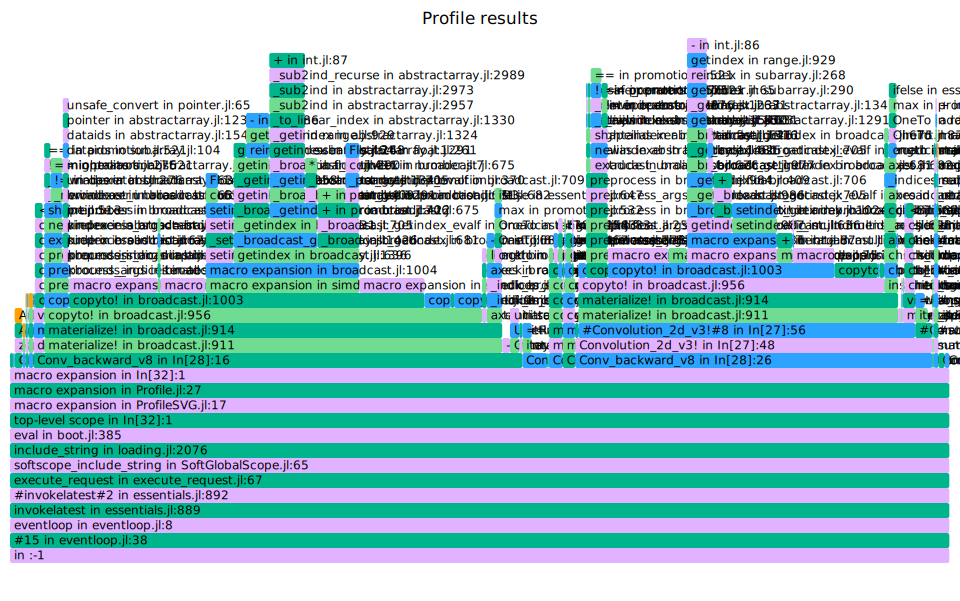

In [32]:
@profview for i in 1:6000 Conv_backward_v8(input, weights, bias, gradient) end